In [1]:
import pandas as pd
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Data

In [2]:
ll = pd.read_csv('../data/data1.csv')
ll = ll.set_index('Date')

ll = -100*(np.log(ll)-np.log(ll.shift(1)))
ll = ll.iloc[1:]

ll = ll.rename_axis('Loss', axis=1)
ll.columns = [x[4:] for x in ll.columns]

# Framework Functions

In [3]:
def rv2_transform(x):
    y = np.log(1+np.exp(x))
    y = -1/np.log(y.rank()/(len(y)+1))
    y = np.sqrt(y)
    return y

In [4]:
def tail_mx(df):

    z = df.apply(rv2_transform, axis=0)

    r = z.apply(lambda x: np.linalg.norm(x,2), axis=1)
    w = z.div(r, axis=0)

    n   = len(r)
    r0  = np.quantile(r,0.95)
    nr0 = len(r[r>r0])
    m = (r0**2)*nr0/n

    S = (m/nr0) * w[r>r0].transpose().dot(w[r>r0])
    
    return S

In [5]:
def plot_mx(S):
    
    M = np.array(S.round(2))
    M[np.triu_indices(len(S),1)] = np.nan
    M = pd.DataFrame(M, index=S.index, columns=S.columns)

    fig = px.imshow(M, color_continuous_scale='Blues', text_auto=True, aspect='auto')
    
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [6]:
def plot_loadings(u):
    
    fig = px.imshow(u.round(2), color_continuous_scale='RdBu', range_color=[-1,1], text_auto=True, aspect='auto')
    
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [7]:
def plot_scores(v):
    
    fig = make_subplots(rows=3, cols=1)

    for i in range(3):
        fig.add_trace(
            go.Scatter(x=v.index, y=v.iloc[:,i]),
            row=i+1, col=1
        )
        fig.update_yaxes(title_text='v'+str(i+1), row=i+1, col=1)

    fig.update_layout(showlegend=False, height=1000, width=1500)
    
    return fig

In [8]:
def plot_scores_pairs(v):
    
    fig = make_subplots(rows=1, cols=3)

    for i in range(3):
        for j in range(i+1,3):
            fig.add_trace(
                go.Scatter(x=v.iloc[:,i], y=v.iloc[:,j], mode='markers'),
                row=1, col=i+j
            )
            fig.update_xaxes(title_text='v'+str(i+1), row=1, col=i+j)
            fig.update_yaxes(title_text='v'+str(j+1), row=1, col=i+j)

    a = v.iloc[:,:3].min().min()-1
    b = v.iloc[:,:3].max().max()+1
    fig.update_xaxes(range=(a,b), row=1, col=1)
    fig.update_yaxes(range=(a,b), row=1, col=1)
    fig.update_xaxes(range=(a,b), row=1, col=2)
    fig.update_yaxes(range=(a,b), row=1, col=2)
    fig.update_xaxes(range=(a,b), row=1, col=3)
    fig.update_yaxes(range=(a,b), row=1, col=3)

    fig.update_layout(showlegend=False, height=500, width=1500)

    return fig

# Tail Dependence Matrix
## Multivariate Estimation

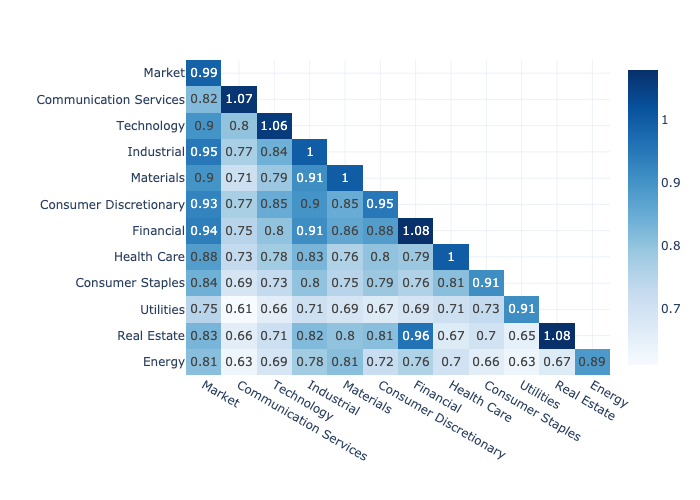

In [9]:
S = tail_mx(ll)

fig = plot_mx(S)
fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

## Pair By Pair Estimation
### Original Diagonal

In [10]:
S = []
for i in range(12):
    row = []
    for j in range(12):
        s = tail_mx(ll.iloc[:,[i,j]])
        row.append(s.iloc[0,1])
    S.append(row)
    
S = pd.DataFrame(S, index=ll.columns, columns=ll.columns)

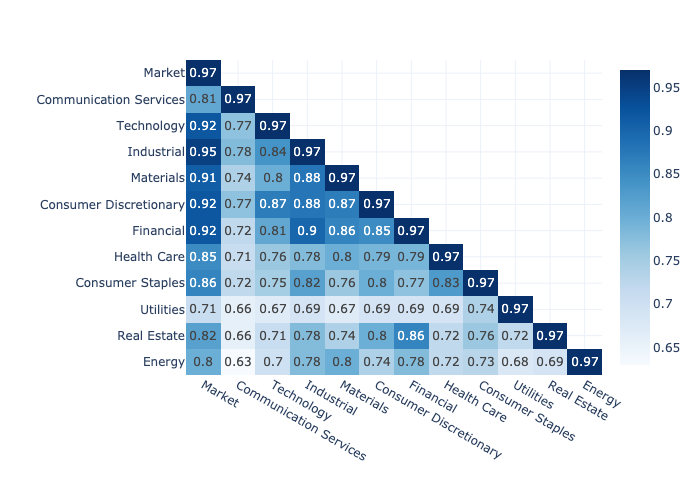

In [11]:
fig = plot_mx(S)
#fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

### Scaled Diagonal

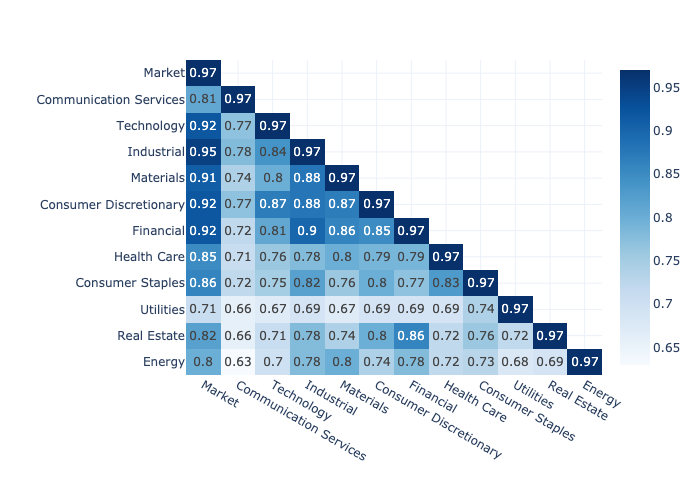

In [12]:
S_pairs = S/S.iloc[0,0]

fig = plot_mx(S)
#fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

In [13]:
tail_mx(ll.iloc[:,[0,1]])

,Market,Communication Services
Market,1.005942,0.814667
Communication Services,0.814667,0.973849


In [14]:
tail_mx(ll.iloc[:,[0,10]])

,Market,Real Estate
Market,1.010936,0.817704
Real Estate,0.817704,1.011199


In [15]:
tail_mx(ll.iloc[:,[0,0]])

,Market,Market
Market,0.974506,0.974506
Market,0.974506,0.974506


# Eigen Decomposition

## Version 1

In [16]:
S = tail_mx(ll)

e,u = np.linalg.eig(S)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns, columns=['u'+str(i) for i in range(1,6)])

#v = ll.applymap(lambda x: max(x,0)).dot(u)
v = np.log(np.exp(ll.apply(rv2_transform, axis=0))-1).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

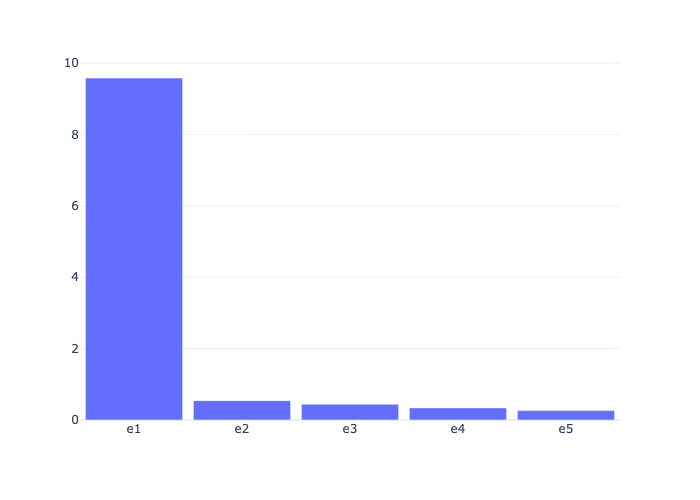

In [17]:
px.bar(x=['e'+str(i) for i in range(1,6)], y=e).update_layout(
    xaxis_title='', yaxis_title='', bargap=0.1, width=700
)

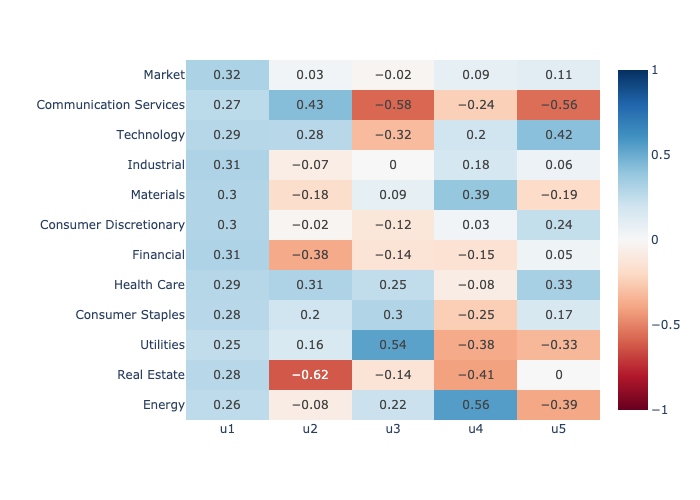

In [18]:
fig = plot_loadings(u)
fig.write_image('../figures/tail_loadings.jpeg', scale=2)
fig.show()

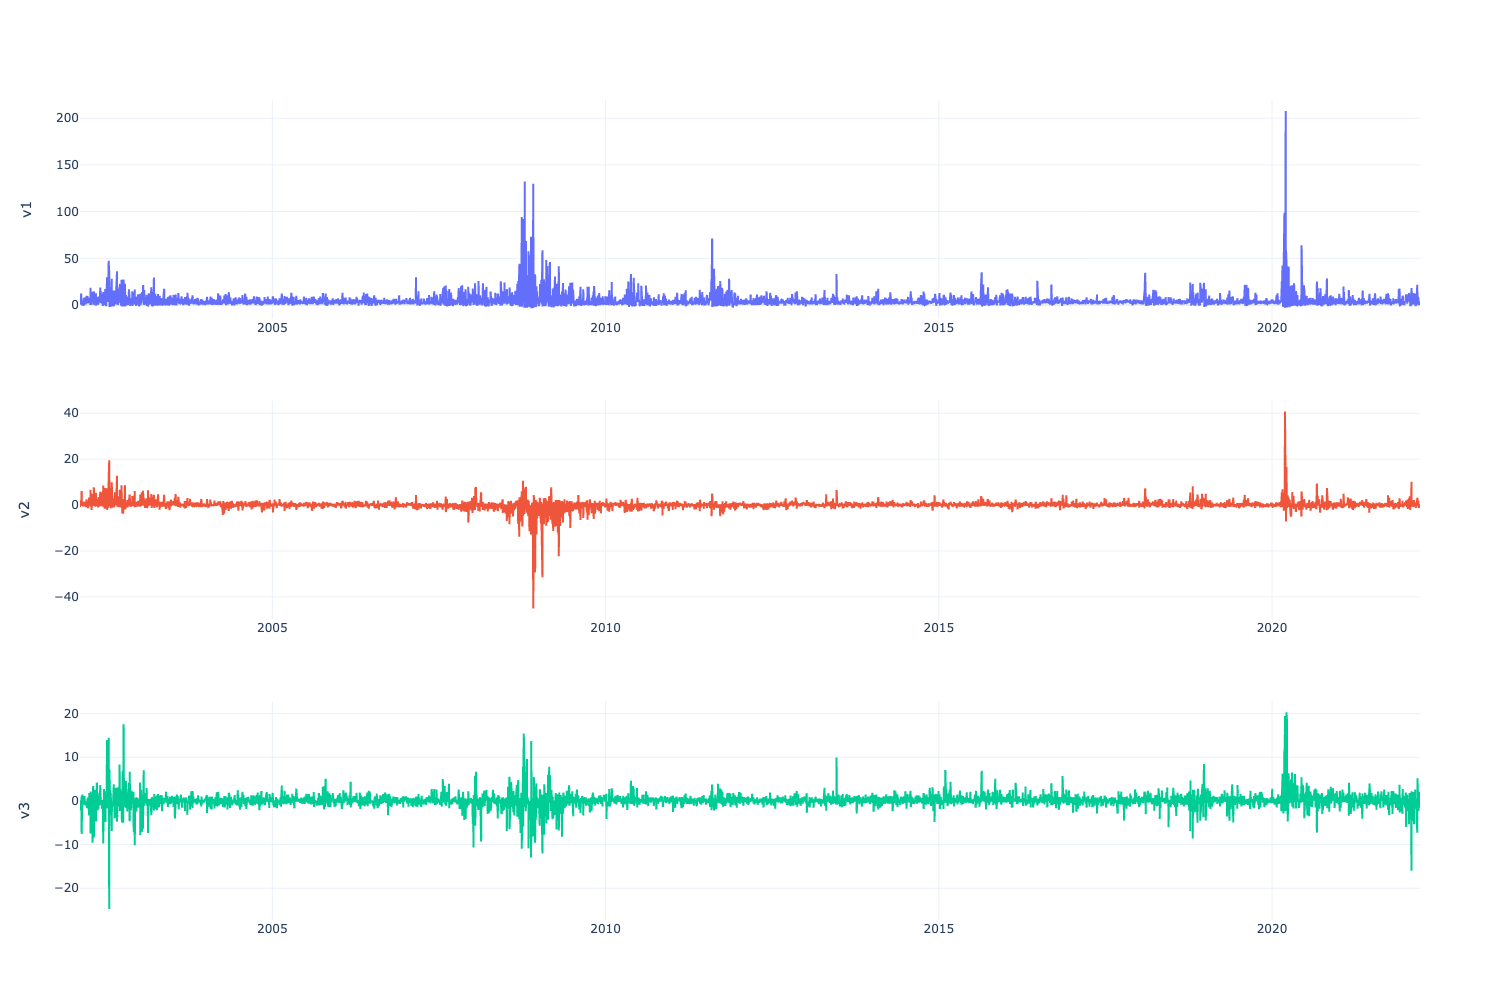

In [19]:
fig = plot_scores(v)
fig.write_image('../figures/tail_scores.jpeg', scale=2)
fig.show()

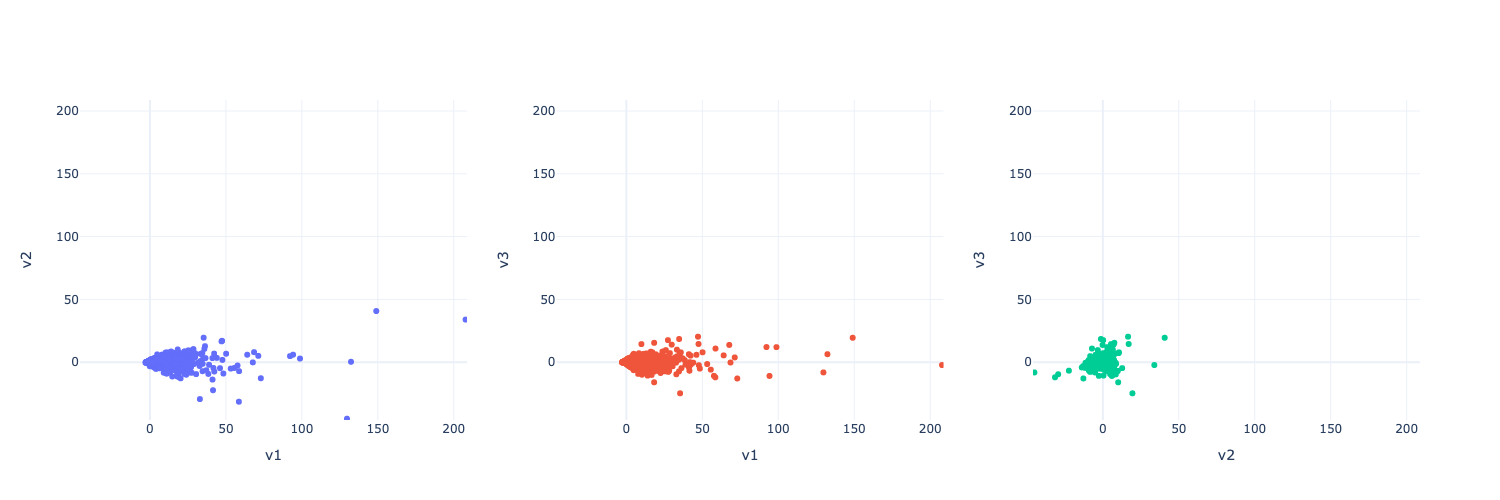

In [20]:
fig = plot_scores_pairs(v)
fig.write_image('../figures/tail_scores_scatter.jpeg', scale=2)
fig.show()

## Version 2

In [21]:
e,u = np.linalg.eig(S_pairs)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns, columns=['u'+str(i) for i in range(1,6)])

#v = ll.applymap(lambda x: max(x,0)).dot(u)
v = np.log(np.exp(ll.apply(rv2_transform, axis=0))-1).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

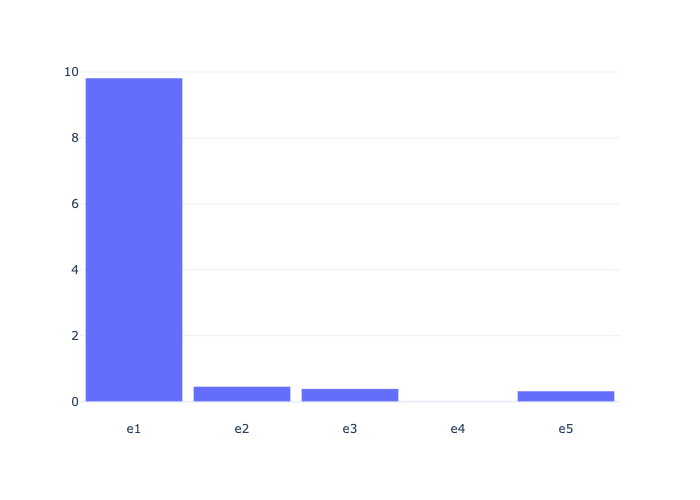

In [22]:
px.bar(x=['e'+str(i) for i in range(1,6)], y=e).update_layout(
    xaxis_title='', yaxis_title='', bargap=0.1, width=700
)

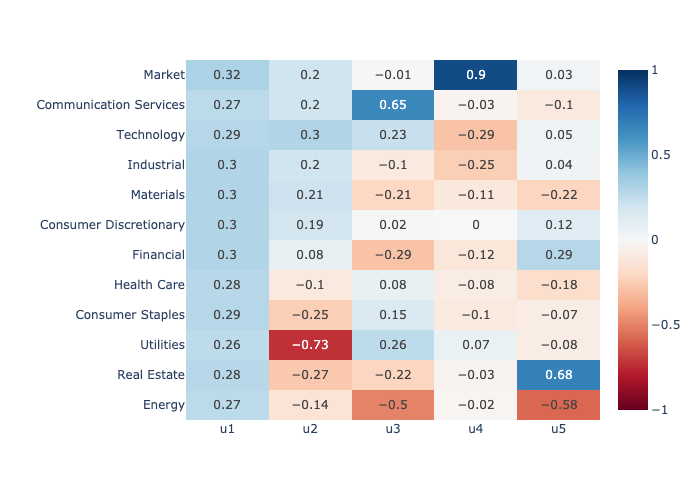

In [23]:
fig = plot_loadings(u)
#fig.write_image('../figures/tail_loadings.jpeg', scale=2)
fig.show()

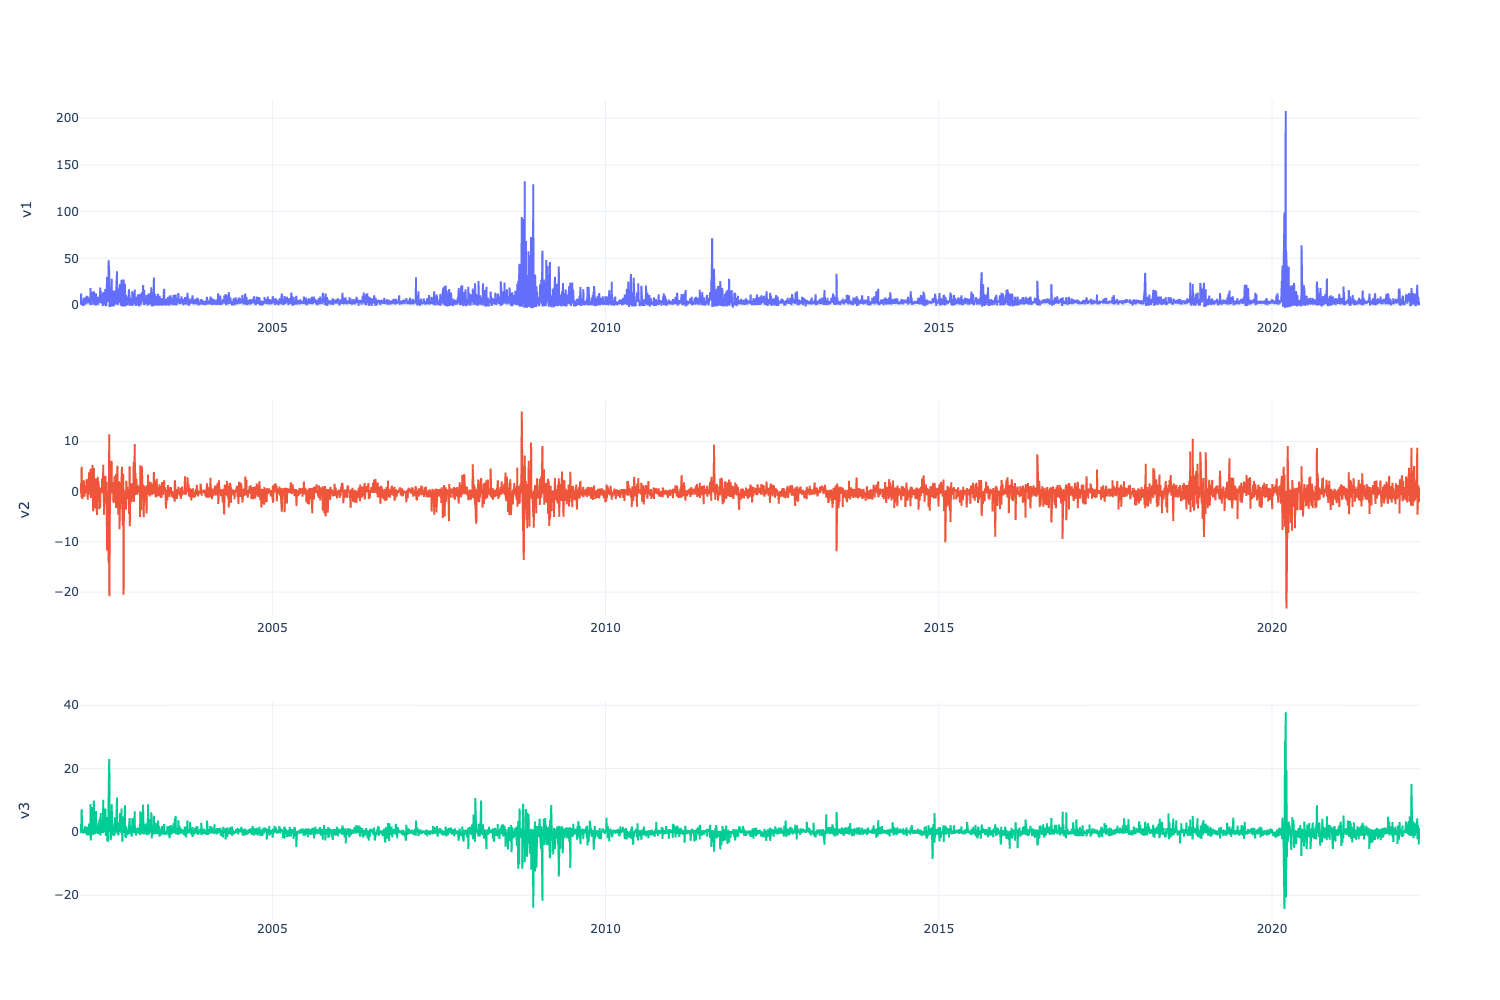

In [24]:
fig = plot_scores(v)
#fig.write_image('../figures/tail_scores.jpeg', scale=2)
fig.show()

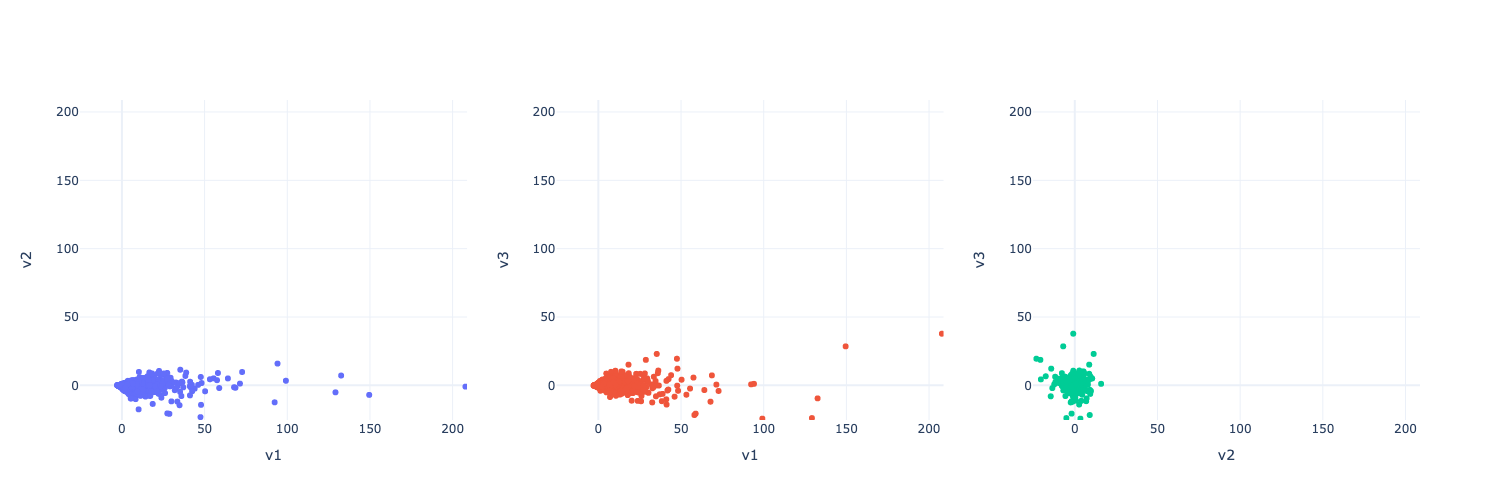

In [25]:
fig = plot_scores_pairs(v)
#fig.write_image('../figures/tail_scores_scatter.jpeg', scale=2)
fig.show()

## Sectors Only - No Market

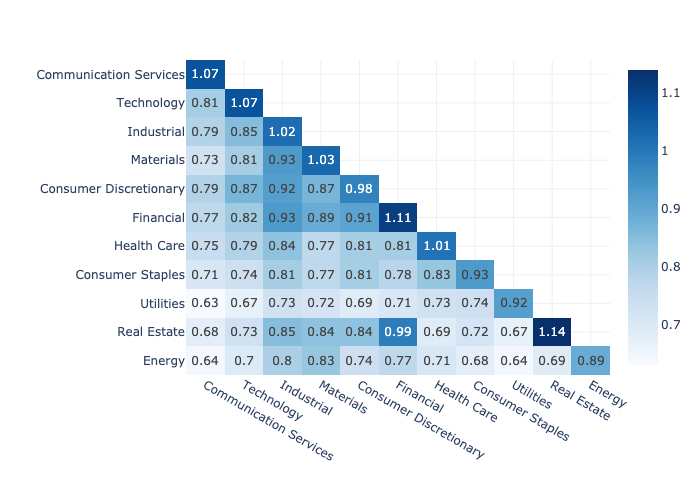

In [26]:
S = tail_mx(ll.iloc[:,1:])

fig = plot_mx(S)
fig.write_image('../figures/tail_matrix_nom.jpeg', scale=2)
fig.show()

In [27]:
e,u = np.linalg.eig(S)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns[1:], columns=['u'+str(i) for i in range(1,6)])
u.iloc[:,0] *= -1

#v = ll.iloc[:,1:].applymap(lambda x: max(x,0)).dot(u)
v = np.log(np.exp(ll.iloc[:,1:].apply(rv2_transform, axis=0))-1).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

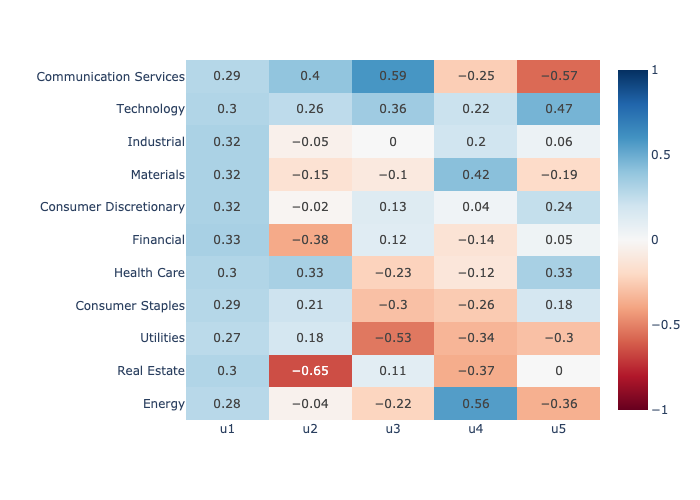

In [28]:
fig = plot_loadings(u)
fig.write_image('../figures/tail_loadings_nom.jpeg', scale=2)
fig.show()

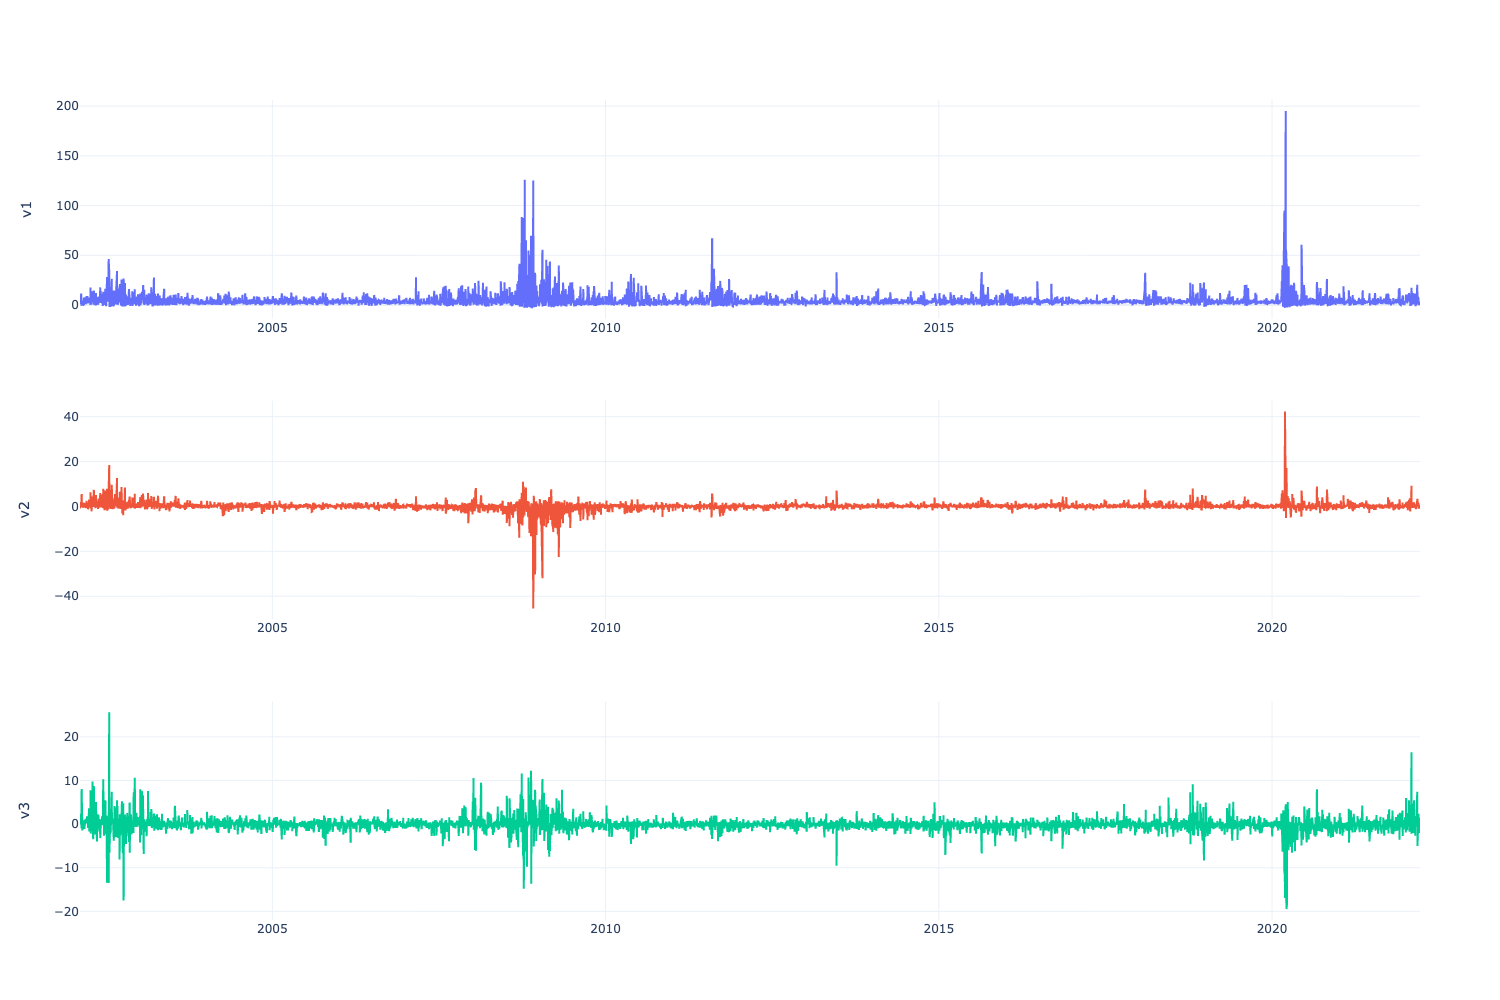

In [29]:
fig = plot_scores(v)
#fig.write_image('../figures/tail_scores_nom.jpeg', scale=2)
fig.show()

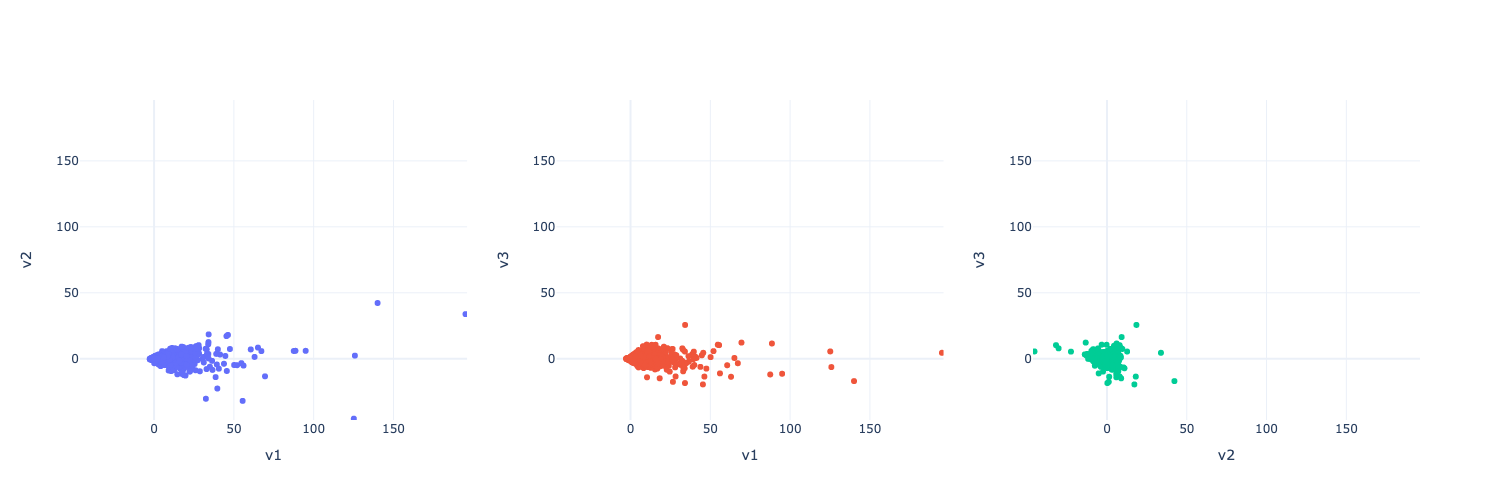

In [30]:
fig = plot_scores_pairs(v)
#fig.write_image('../figures/tail_scores_scatter_nom.jpeg', scale=2)
fig.show()

# Graph
## Partial Correlation

In [31]:
def part_corr(S, precision=False):
    
    if precision:
        D = S
    else:
        D = np.linalg.pinv(S.values)
        
    D = pd.DataFrame(D, index=S.index, columns=S.columns)    
    d = pd.DataFrame(np.diag(np.diag(D)**(-1/2)), index=S.index, columns=S.columns)

    G = -d.dot(D).dot(d)

    for i in range(len(G)):
        G.iloc[i,i] = 1
    
    return G

In [32]:
def plot_g(G,u=0):
    
    M = np.array(G.applymap(lambda x: 0 if np.abs(x)<u else x).round(2))
    M[np.triu_indices(len(S),1)] = np.nan
    M = pd.DataFrame(M, index=G.columns, columns=G.columns)

    fig = px.imshow(M, color_continuous_scale='RdBu', range_color=[-1,1], text_auto=True, aspect='auto')
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [33]:
S = tail_mx(ll.iloc[:,1:])
G = part_corr(S)

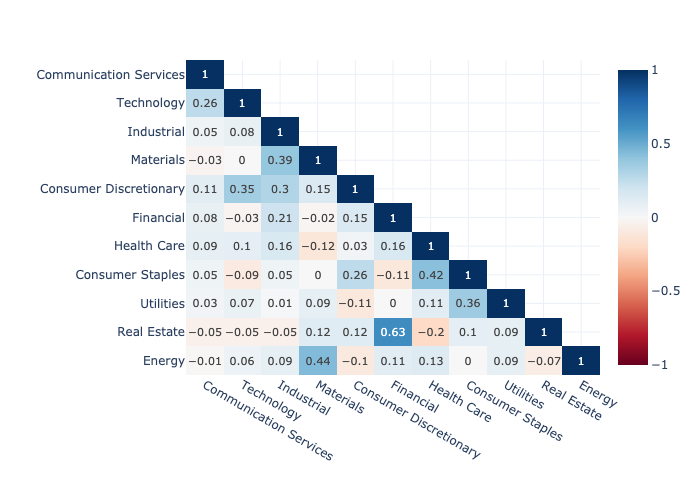

In [34]:
fig = plot_g(G)
fig.write_image('../figures/pcor_tail.jpeg', scale=2)
fig.show()

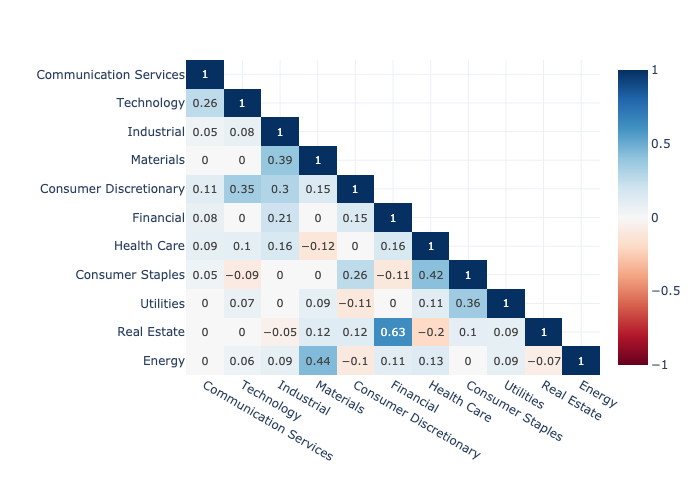

In [35]:
fig = plot_g(G,0.05)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

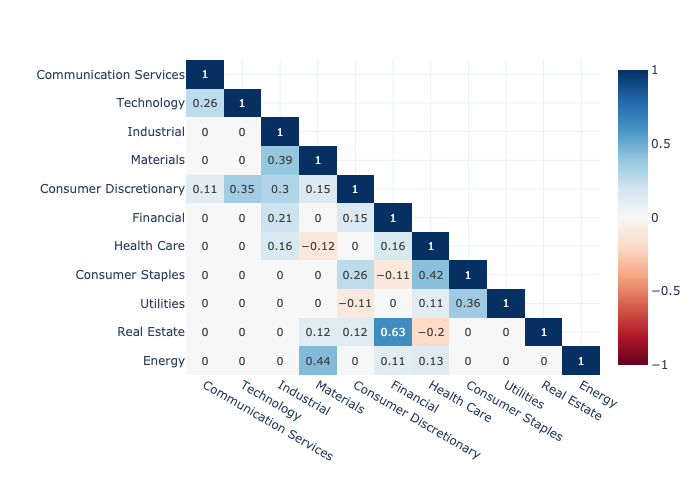

In [36]:
fig = plot_g(G,0.1)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

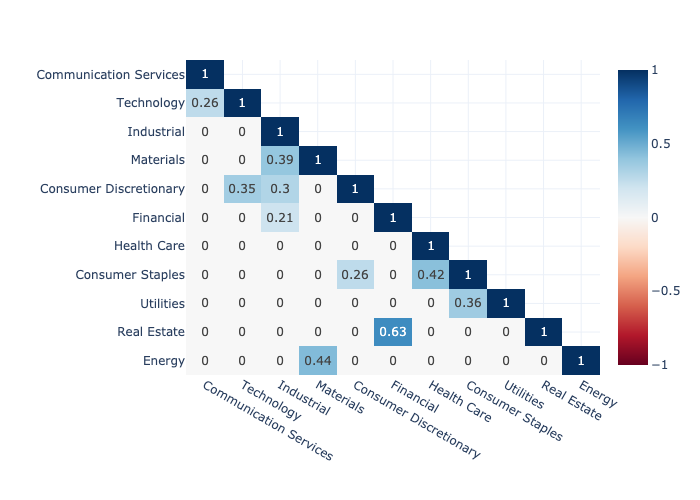

In [37]:
fig = plot_g(G,0.2)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

## Graphical Lasso
### glasso on tail dependence matrix

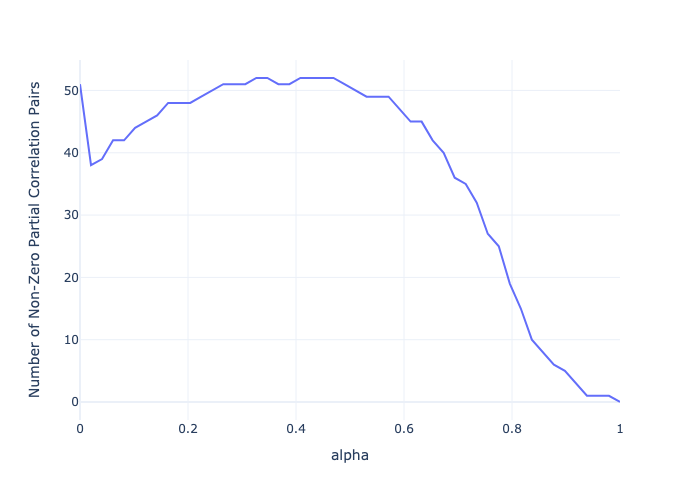

In [38]:
from sklearn.covariance import graphical_lasso

nonzero = []

for alpha in np.linspace(0,1,50):
    cov, prec = graphical_lasso(emp_cov=np.array(S), alpha=alpha)
    cov = pd.DataFrame(cov, index=S.index, columns=S.columns)
    prec = pd.DataFrame(prec, index=S.index, columns=S.columns)
    G = part_corr(prec,True).round(2)
    nonzero.append(int(((G!=0).sum().sum()-len(G))/2))
    
fig = px.line(x=np.linspace(0,1,50), y=nonzero)
fig.update_layout(xaxis_title='alpha', yaxis_title='Number of Non-Zero Partial Correlation Pairs', width=700)
fig.write_image('../figures/glasso_val.jpeg', scale=2)
fig.show()

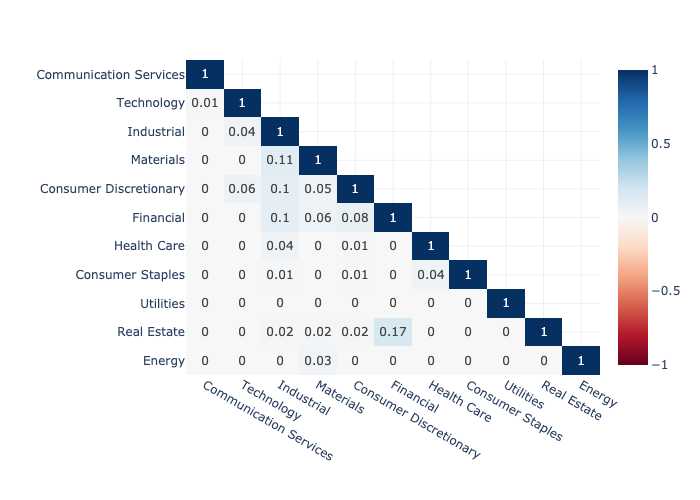

In [39]:
cov, prec = graphical_lasso(emp_cov=np.array(S), alpha=0.8)
cov = pd.DataFrame(cov, index=S.index, columns=S.columns)
prec = pd.DataFrame(prec, index=S.index, columns=S.columns)

gl = part_corr(prec,True).round(2)

fig = plot_g(gl)
fig.write_image('../figures/pcor_glasso.jpeg', scale=2)
fig.show()

### glasso cross-validation

In [40]:
z = ll.iloc[:,1:].apply(rv2_transform, axis=0)
r = z.apply(lambda x: np.linalg.norm(x,2), axis=1)
w = z.div(r, axis=0)

n   = len(r)
r0  = np.quantile(r,0.95)
nr0 = len(r[r>r0])
m = (r0**2)*nr0/n

W = w[r>r0]

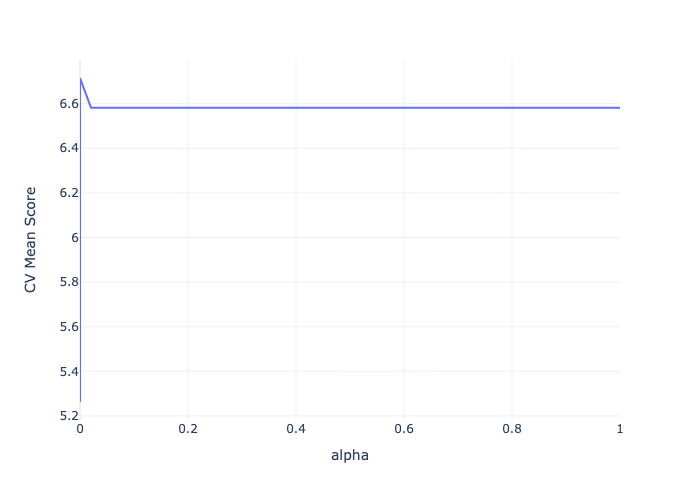

In [41]:
from sklearn.covariance import GraphicalLassoCV

glcv = GraphicalLassoCV(alphas=np.linspace(0,1,50).tolist(), cv=5).fit(W)

fig = px.line(x=glcv.cv_results_['alphas'], y=glcv.cv_results_['mean_score'])
fig.update_layout(xaxis_title='alpha', yaxis_title='CV Mean Score', width=700)
fig.show()

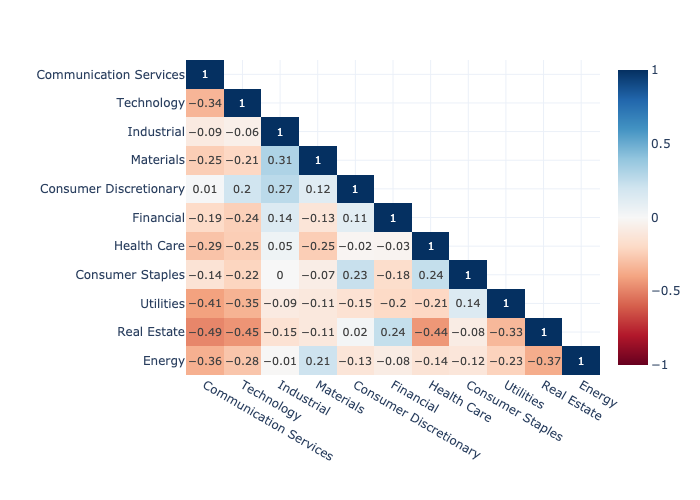

In [42]:
cov = pd.DataFrame(glcv.covariance_, index=W.columns, columns=W.columns)
G_glcv = part_corr(cov).round(2)
plot_g(G_glcv)

## Draw Network
Based on the sparse partial correlation matrix.

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

sectors = [x.replace(' ','\n') for x in S.columns]

# Color Map
c1 = "#636EFA" #blue
c2 = "#EF553B" #red
c3 = "#00CC96" #green
c4 = "#AB63FA" #purple
c5 = "#FECB52" #yellow
c6 = "#19D3F3" #lightblue
c7 = "grey"

label = [c6,c1,c2,c2,c2,c2,c3,c3,c4,c7,c5]
cluster = [6,1,0,0,0,0,2,2,3,4,5]
nodes = [(sectors[i],{'color': label[i], 'subset': cluster[i]}) for i in range(11)]

### alpha=0.8

In [44]:
graph = nx.Graph()
graph.add_nodes_from(nodes)

for i in range(11):
    for j in range(i+1,11):
        if gl.iloc[i,j]!=0:
            graph.add_edge(sectors[i], sectors[j])

In [45]:
pos = {
    'Communication\nServices': np.array([-0.62836728,  0.94358073]),
    'Technology': np.array([-3.41182309e-04,  6.09279039e-01]),
    'Industrial': np.array([ 0.71507479, -0.21362591]),
    'Materials': np.array([ 0.12694559, -0.70727804]),
    'Consumer\nDiscretionary': np.array([-0.06356016, -0.08451729]),
    'Financial': np.array([0.80202844, 0.29537626]),
    'Health\nCare': np.array([-0.48268291, -0.79223559]),
    'Consumer\nStaples': np.array([-0.69405995,  0.24603443]),
    'Utilities': np.array([-1, -0.30579802]),
    'Real\nEstate': np.array([ 0.69633715, -0.89955404]),
    'Energy': np.array([0.5286255 , 0.90873844])
}

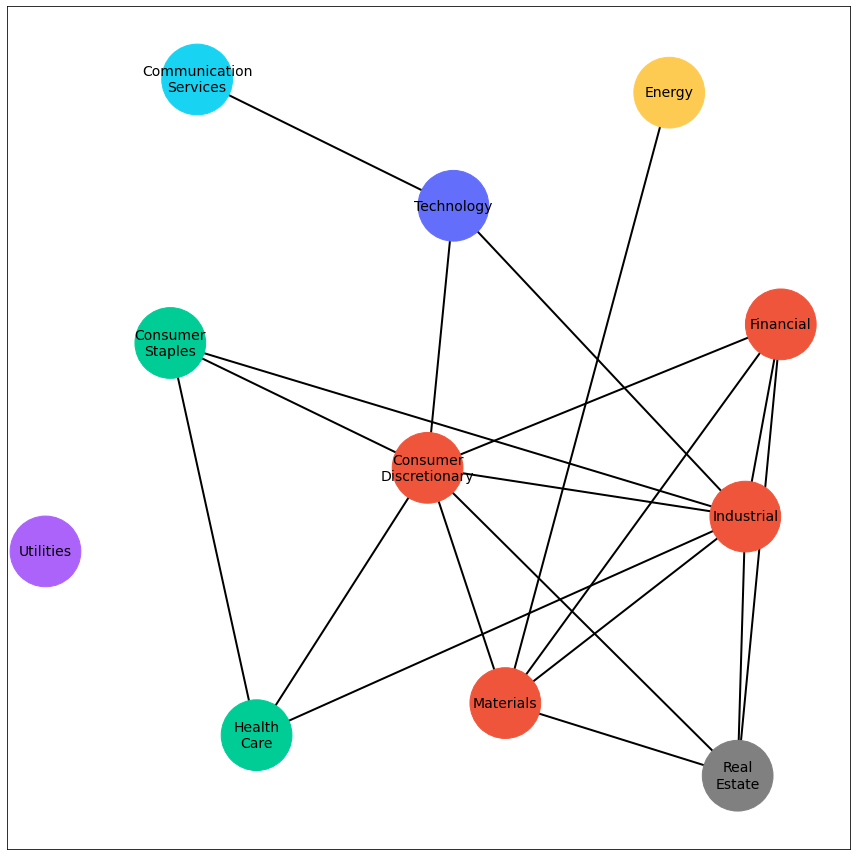

In [46]:
plt.figure(figsize=(12,12))

nx.draw_networkx_nodes(
    graph, pos, node_shape='o', node_size=0.5*1e4,
    node_color=[graph.nodes[sectors[i]]['color'] for i in range(11)]
)

nx.draw_networkx_labels(graph, pos, font_size=14)
nx.draw_networkx_edges(graph, pos, width=2)

plt.tight_layout()
#plt.savefig('../figures/glasso_network.jpeg', dpi=100)
plt.show()

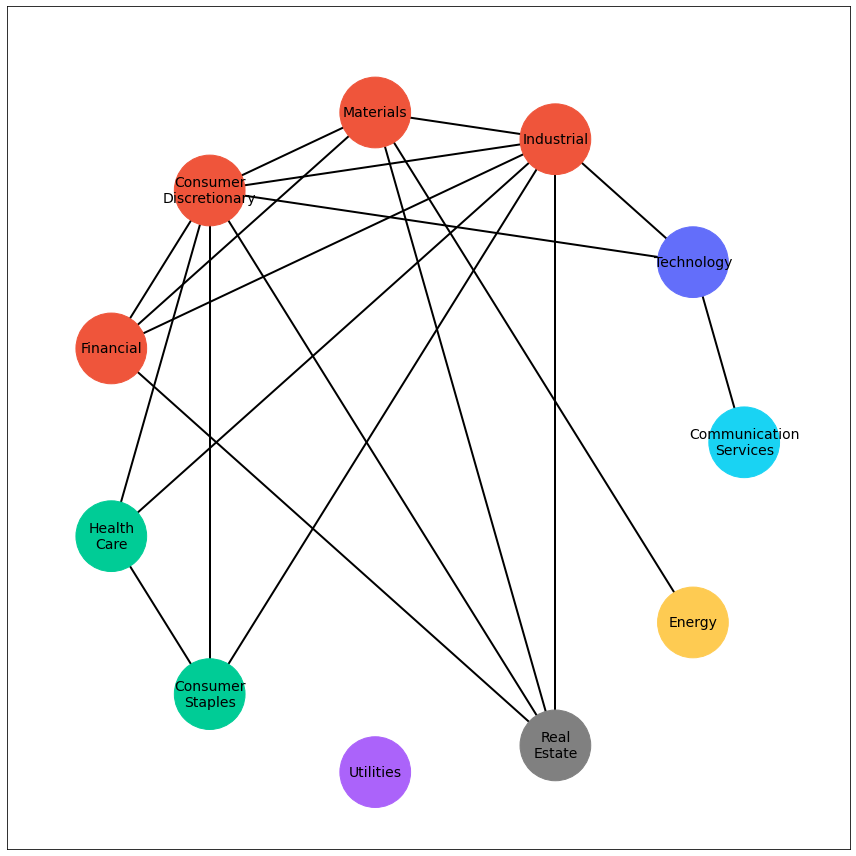

In [47]:
pos = nx.circular_layout(graph)

plt.figure(figsize=(12,12))

nx.draw_networkx_nodes(
    graph, pos, node_shape='o', node_size=0.5*1e4,
    node_color=[graph.nodes[sectors[i]]['color'] for i in range(11)]
)

nx.draw_networkx_labels(graph, pos, font_size=14)
nx.draw_networkx_edges(graph, pos, width=2)

axis = plt.gca()
axis.set_xlim([1.1*x for x in axis.get_xlim()])
axis.set_ylim([1.1*y for y in axis.get_ylim()])
plt.tight_layout()

plt.savefig('../figures/glasso_network_8.jpeg', dpi=100)
plt.show()

### alpha=0.85

In [48]:
cov, prec = graphical_lasso(emp_cov=np.array(S), alpha=0.85)
cov = pd.DataFrame(cov, index=S.index, columns=S.columns)
prec = pd.DataFrame(prec, index=S.index, columns=S.columns)

gl = part_corr(prec,True).round(2)

In [49]:
graph = nx.Graph()
graph.add_nodes_from(nodes)

for i in range(11):
    for j in range(i+1,11):
        if gl.iloc[i,j]!=0:
            graph.add_edge(sectors[i], sectors[j])

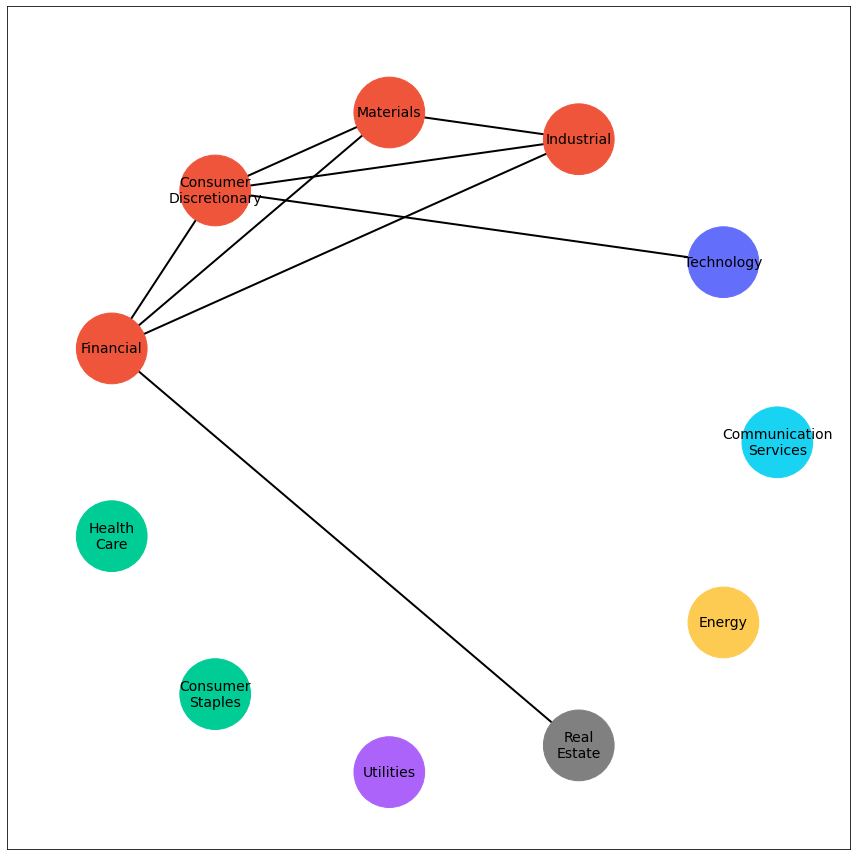

In [50]:
#pos = nx.circular_layout(graph)

plt.figure(figsize=(12,12))

nx.draw_networkx_nodes(
    graph, pos, node_shape='o', node_size=0.5*1e4,
    node_color=[graph.nodes[sectors[i]]['color'] for i in range(11)]
)

nx.draw_networkx_labels(graph, pos, font_size=14)
nx.draw_networkx_edges(graph, pos, width=2)

axis = plt.gca()
axis.set_xlim([1.1*x for x in axis.get_xlim()])
axis.set_ylim([1.1*y for y in axis.get_ylim()])
plt.tight_layout()

plt.savefig('../figures/glasso_network_85.jpeg', dpi=100)
plt.show()

# Portfolio Optimization

In [51]:
S = tail_mx(ll.iloc[:,1:])
S

,Communication Services,Technology,Industrial,Materials,Consumer Discretionary,Financial,Health Care,Consumer Staples,Utilities,Real Estate,Energy
Communication Services,1.074947,0.809619,0.786587,0.730227,0.789584,0.772268,0.749556,0.710675,0.629264,0.680458,0.638200
Technology,0.809619,1.068236,0.853261,0.805398,0.867537,0.815053,0.786608,0.738267,0.668226,0.728203,0.703852
Industrial,0.786587,0.853261,1.017642,0.931258,0.917795,0.930802,0.842522,0.811768,0.727308,0.845008,0.796021
Materials,0.730227,0.805398,0.931258,1.030524,0.874875,0.892000,0.774941,0.769743,0.715928,0.838679,0.828691
Consumer Discretionary,0.789584,0.867537,0.917795,0.874875,0.976678,0.907114,0.814459,0.807663,0.694136,0.841491,0.735040
Financial,0.772268,0.815053,0.930802,0.892000,0.907114,1.106741,0.807935,0.777570,0.708215,0.994546,0.769735
Health Care,0.749556,0.786608,0.842522,0.774941,0.814459,0.807935,1.012976,0.834653,0.725839,0.691445,0.714420
Consumer Staples,0.710675,0.738267,0.811768,0.769743,0.807663,0.777570,0.834653,0.930980,0.744234,0.722863,0.678239
Utilities,0.629264,0.668226,0.727308,0.715928,0.694136,0.708215,0.725839,0.744234,0.922418,0.666911,0.643067
Real Estate,0.680458,0.728203,0.845008,0.838679,0.841491,0.994546,0.691445,0.722863,0.666911,1.136600,0.690582


In [52]:
ll.iloc[:,1:].cov()

,Communication Services,Technology,Industrial,Materials,Consumer Discretionary,Financial,Health Care,Consumer Staples,Utilities,Real Estate,Energy
Communication Services,1.893741,1.454812,1.256306,1.301767,1.319319,1.627705,0.970847,0.806015,0.956404,1.426012,1.328235
Technology,1.454812,2.288544,1.635441,1.702313,1.731883,2.016815,1.208979,0.905452,1.022241,1.742255,1.610870
Industrial,1.256306,1.635441,1.842544,1.797399,1.580660,2.148027,1.140413,0.914238,1.036570,1.832686,1.794378
Materials,1.301767,1.702313,1.797399,2.320625,1.626468,2.189135,1.175564,0.945084,1.120823,1.914024,2.125216
Consumer Discretionary,1.319319,1.731883,1.580660,1.626468,1.847406,2.049734,1.123911,0.904802,0.963169,1.847480,1.535749
Financial,1.627705,2.016815,2.148027,2.189135,2.049734,3.655264,1.415993,1.123808,1.261864,2.919174,2.225784
Health Care,0.970847,1.208979,1.140413,1.175564,1.123911,1.415993,1.227992,0.772503,0.848197,1.212646,1.197765
Consumer Staples,0.806015,0.905452,0.914238,0.945084,0.904802,1.123808,0.772503,0.839783,0.786130,1.068588,0.938996
Utilities,0.956404,1.022241,1.036570,1.120823,0.963169,1.261864,0.848197,0.786130,1.536916,1.358803,1.228860
Real Estate,1.426012,1.742255,1.832686,1.914024,1.847480,2.919174,1.212646,1.068588,1.358803,3.741533,1.799773
